# Set Required Args to Activate Modules

In [1]:
# Iterate over provinces for both solar and wind resources
resource_types = ['wind','solar']  #'wind','solar'
countries=['AL'] #'AL, 'BA','XK','ME','MK','RS']

In [2]:
import RES.RESources as RES

for country in countries:
    for resource_type in resource_types:
        required_args = {
            "config_file_path": 'config/config.yaml',
            "region_short_code": country,
            "resource_type": resource_type
        }
        
        # Create an instance of Resources and execute the module
        RES_module = RES.RESources_builder(**required_args)
        RES_module.build(select_top_sites=True,
                         use_pypsa_buses=False)

2025-06-25 09:53:38,482 - INFO - Processing Annual Technology Baseline (ATB) data sourced from NREL...
2025-06-25 09:53:38,483 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.
2025-06-25 09:53:38,638 - INFO - ATB cost datafile: ATBe.parquet loaded
2025-06-25 09:53:38,838 - INFO - Preparing Grid Cells...
2025-06-25 09:53:38,838 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:38,882 - INFO - Cutout already prepared.
2025-06-25 09:53:38,908 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:38,928 - INFO - Cutout already prepared.
2025-06-25 09:53:38,929 - INFO - >> Loading global filters' rasters from GAEZ, trimmed to Albania
2025-06-25 09:53:38,930 - INFO - >> Raster file 'faocmb_2010.tif' already exists locally.
2025-06-25 09:53:38,930 - INFO - >> Raster file 'slpmed05.tif' already exists local

>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cost/atb/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cost/atb/wind'
__________________________________________________
 Initiating wind module for Albania...

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
>> Updated 'cells' saved to data/store/resources_AL.h5 with key 'cells'
>> Updated 'boundary' saved to data/store/resources_AL.h5 with key 'boundary'

    >>> Memory management remarks:
    * After e

2025-06-25 09:53:39,040 - INFO - >> Raster plot saved at: vis/misc/faocmb_2010_raster_AL.png
2025-06-25 09:53:39,129 - INFO - >> Raster plot saved at: vis/misc/slpmed05_raster_AL.png
2025-06-25 09:53:39,237 - INFO - >> Raster plot saved at: vis/misc/exclusion_2017_raster_AL.png
2025-06-25 09:53:39,238 - INFO - All required rasters for GAEZ processed and plotted successfully.
2025-06-25 09:53:39,238 - INFO -  >>> Loading Land_cover layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/lco/AL_faocmb_2010.tif
2025-06-25 09:53:39,238 - INFO -  >>> Loading Terrain_resources layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/ter/AL_slpmed05.tif
2025-06-25 09:53:39,238 - INFO -  >>> Loading Exclusion_areas layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/excl/AL_exclusion_2017.tif
2025-06-25 09:53:39,238 - INFO - >> Loading locally stored OSM data for 'aeroway' from data/downloaded_data/OSM/AL_aeroway.geojson
2025-06-25 09:53:39,253 - INFO - Exclusion Container
 registered raste

Land availability (grid cells) map saved at vis/misc/land_availability_ERA5grid_Albania.png


2025-06-25 09:53:41,585 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:41,604 - INFO - Cutout already prepared.
2025-06-25 09:53:41,604 - INFO - 'windspeed_ERA5' already present in the store information.
2025-06-25 09:53:41,612 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:41,722 - INFO - >> 0 cells have been filtered due to Windspeed filter [0-50 m/s].
>>> Cleaned data loaded for 583237 GWA cells


Land availability map (excluder resolution) saved at vis/misc/land_availability_excluderResolution_Albania.png
>> Total ERA5 cells loaded : 133 [each with .025 deg. (~30km) resolution ]
>> Updated 'cells' saved to data/store/resources_AL.h5 with key 'cells'

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


2025-06-25 09:53:41,783 - INFO - >> Global Wind Atlas (GWA) Cells loaded. Size: 583237
2025-06-25 09:53:41,783 - INFO - >> Mapping 583237 GWA Cells to 135 ERA5 Cells...
2025-06-25 09:53:41,784 - INFO - >> Updating aggregated values for ERA5 Cell's...
2025-06-25 09:53:43,625 - INFO - >> Loading ERA5 Cutout
2025-06-25 09:53:43,626 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:43,645 - INFO - Cutout already prepared.
2025-06-25 09:53:43,645 - INFO - >> 135 Grid Cells from Store Cutout


>> Updated 'cells' saved to data/store/resources_AL.h5 with key 'cells'
  └─> Preparing Timeseries for the Cells...

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
  └> Rescaling ERA5 windspeed with GWA windspeed


2025-06-25 09:53:47,695 - INFO - adding a cut-out wind speed to the turbine power curve at V=22.0 m/s.
2025-06-25 09:53:47,695 - INFO - Convert and aggregate 'wind'.


Fetching Turbine: '3.2M114_NES' data from OEDB
>> Loading turbine config from: data/downloaded_data/OEDB/3.2M114_NES.yaml
>> selected Wind Turbine  Model : 3.2M114 NES @ 93.0m Hub Height


2025-06-25 09:53:49,180 - INFO - >> Calculating CF mean from the 8760 data points for each Cell ...
2025-06-25 09:53:49,181 - INFO - >> Total Grid Cells: 135, >> Timeseries Generated for: 135, >> Matched Sites: (8760, 135)
2025-06-25 09:53:49,181 - INFO - >> Calculating 'wind_CF_mean' for 135 Cells...
2025-06-25 09:53:49,370 - INFO - >> Loading locally stored OSM data for 'power' from data/downloaded_data/OSM/AL_power.geojson


>> Updated 'cells' saved to data/store/resources_AL.h5 with key 'cells'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'timeseries/wind'


2025-06-25 09:53:50,291 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:50,311 - INFO - Cutout already prepared.



    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


2025-06-25 09:53:51,774 - INFO - >> Preparing spatial clusters for 135 Cells


>> Updated 'cells' saved to data/store/resources_AL.h5 with key 'cells'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'lines'
>> Calculating Score for each Cell...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cells'
>> Calculating Score for each Cell...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cells'
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Dibër - Optimal k for LCOE_wind based clustering: 2

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Lezhë - Optimal k for LCOE_wind based clustering: 2

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...


2025-06-25 09:53:53,006 - INFO -  Preparing Clusters...
2025-06-25 09:53:53,006 - INFO -  Creating cluster for Dibër 1/12
2025-06-25 09:53:53,013 - INFO -  Creating cluster for Lezhë 2/12
2025-06-25 09:53:53,020 - INFO -  Creating cluster for Shkodër 3/12
2025-06-25 09:53:53,028 - INFO -  Creating cluster for Elbasan 4/12


Zone Kukës - Optimal k for LCOE_wind based clustering: 3

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Vlorë - Optimal k for LCOE_wind based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 12 zones and saved to cell dataframe.

>>> Mapping the Optimal Number of Clusters for Each region ...


2025-06-25 09:53:53,040 - INFO -  Creating cluster for Korçë 5/12
2025-06-25 09:53:53,052 - INFO -  Creating cluster for Tiranë 6/12
2025-06-25 09:53:53,063 - INFO -  Creating cluster for Durrës 7/12
2025-06-25 09:53:53,073 - INFO -  Creating cluster for Fier 8/12
2025-06-25 09:53:53,086 - INFO -  Creating cluster for Berat 9/12
2025-06-25 09:53:53,099 - INFO -  Creating cluster for Gjirokastër 10/12
2025-06-25 09:53:53,113 - INFO -  Creating cluster for Kukës 11/12
2025-06-25 09:53:53,125 - INFO -  Creating cluster for Vlorë 12/12
2025-06-25 09:53:53,141 - INFO -  Culsters Created and a list generated to map the Cells inside each Cluster...
2025-06-25 09:53:53,155 - INFO - >> Preparing representative profiles for 39 clusters
2025-06-25 09:53:53,279 - INFO - >> Units dictionary created and saved to 'data/units_dictionary.xlsx'
2025-06-25 09:53:53,300 - INFO - >> Preparing spatial clusters for 135 Cells


>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'clusters/wind'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'dissolved_indices/wind'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'timeseries/clusters/wind'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'units'
>> Calculating Score for each Cell...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cells'
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Dibër - Optimal k for LCOE_wind based clustering: 2

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Lezhë - Optimal k for LCOE_wind based clustering: 2

>>> K-means clustering Elbow plots generated for each region based on the Score for ea

2025-06-25 09:53:54,507 - INFO -  Preparing Clusters...
2025-06-25 09:53:54,507 - INFO -  Creating cluster for Dibër 1/12
2025-06-25 09:53:54,514 - INFO -  Creating cluster for Lezhë 2/12
2025-06-25 09:53:54,521 - INFO -  Creating cluster for Shkodër 3/12
2025-06-25 09:53:54,528 - INFO -  Creating cluster for Elbasan 4/12
2025-06-25 09:53:54,540 - INFO -  Creating cluster for Korçë 5/12
2025-06-25 09:53:54,552 - INFO -  Creating cluster for Tiranë 6/12
2025-06-25 09:53:54,562 - INFO -  Creating cluster for Durrës 7/12
2025-06-25 09:53:54,573 - INFO -  Creating cluster for Fier 8/12
2025-06-25 09:53:54,586 - INFO -  Creating cluster for Berat 9/12
2025-06-25 09:53:54,600 - INFO -  Creating cluster for Gjirokastër 10/12
2025-06-25 09:53:54,615 - INFO -  Creating cluster for Kukës 11/12
2025-06-25 09:53:54,628 - INFO -  Creating cluster for Vlorë 12/12
2025-06-25 09:53:54,642 - INFO -  Culsters Created and a list generated to map the Cells inside each Cluster...
2025-06-25 09:53:54,657 - 

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 12 zones and saved to cell dataframe.

>>> Mapping the Optimal Number of Clusters for Each region ...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'clusters/wind'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'dissolved_indices/wind'


2025-06-25 09:53:54,915 - INFO - Processing Annual Technology Baseline (ATB) data sourced from NREL...
2025-06-25 09:53:54,915 - INFO - Directory 'data/downloaded_data/NREL/ATB/ATBe.parquet' found locally.


>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'timeseries/clusters/wind'
>>> Selecting TOP Sites to for 20 GW Capacity Investment...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 20 GW PV
____________________________________________________________________________________________________
____________________________________________________________
     Top Sites(clusters) from wind module saved to data/store/resources_AL.h5 for Albania...
____________________________________________________________
wind clusters exported to :results/linking


2025-06-25 09:53:55,073 - INFO - ATB cost datafile: ATBe.parquet loaded
2025-06-25 09:53:55,303 - INFO - Preparing Grid Cells...
2025-06-25 09:53:55,304 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:55,325 - INFO - Cutout already prepared.
2025-06-25 09:53:55,352 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:55,373 - INFO - Cutout already prepared.
2025-06-25 09:53:55,373 - INFO - >> Loading global filters' rasters from GAEZ, trimmed to Albania
2025-06-25 09:53:55,374 - INFO - >> Raster file 'faocmb_2010.tif' already exists locally.
2025-06-25 09:53:55,374 - INFO - >> Raster file 'slpmed05.tif' already exists locally.
2025-06-25 09:53:55,375 - INFO - >> Raster file 'exclusion_2017.tif' already exists locally.
2025-06-25 09:53:55,375 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GA

>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cost/atb/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cost/atb/wind'
__________________________________________________
 Initiating solar module for Albania...

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
>> Updated 'cells' saved to data/store/resources_AL.h5 with key 'cells'
>> Updated 'boundary' saved to data/store/resources_AL.h5 with key 'boundary'

    >>> Memory management remarks:
    * After 

2025-06-25 09:53:55,464 - INFO - >> Raster plot saved at: vis/misc/faocmb_2010_raster_AL.png
2025-06-25 09:53:55,552 - INFO - >> Raster plot saved at: vis/misc/slpmed05_raster_AL.png
2025-06-25 09:53:55,658 - INFO - >> Raster plot saved at: vis/misc/exclusion_2017_raster_AL.png
2025-06-25 09:53:55,658 - INFO - All required rasters for GAEZ processed and plotted successfully.
2025-06-25 09:53:55,658 - INFO -  >>> Loading Land_cover layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/lco/AL_faocmb_2010.tif
2025-06-25 09:53:55,659 - INFO -  >>> Loading Terrain_resources layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/ter/AL_slpmed05.tif
2025-06-25 09:53:55,659 - INFO -  >>> Loading Exclusion_areas layers from data/downloaded_data/GAEZ/Rasters_in_use/LR/excl/AL_exclusion_2017.tif
2025-06-25 09:53:55,659 - INFO - >> Loading locally stored OSM data for 'aeroway' from data/downloaded_data/OSM/AL_aeroway.geojson
2025-06-25 09:53:55,673 - INFO - Exclusion Container
 registered raste

Land availability (grid cells) map saved at vis/misc/land_availability_ERA5grid_Albania.png


2025-06-25 09:53:57,903 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:57,923 - INFO - Cutout already prepared.
2025-06-25 09:53:57,923 - INFO - GWA Cells not configured for solar.
2025-06-25 09:53:57,931 - INFO - >> Loading ERA5 Cutout
2025-06-25 09:53:57,931 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:57,951 - INFO - Cutout already prepared.
2025-06-25 09:53:57,951 - INFO - >> 135 Grid Cells from Store Cutout
2025-06-25 09:53:57,952 - INFO - Convert and aggregate 'pv'.


Land availability map (excluder resolution) saved at vis/misc/land_availability_excluderResolution_Albania.png
>> Total ERA5 cells loaded : 133 [each with .025 deg. (~30km) resolution ]
>> Updated 'cells' saved to data/store/resources_AL.h5 with key 'cells'

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        
  └─> Preparing Timeseries for the Cells...

    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This ke

2025-06-25 09:53:58,597 - INFO - >> Calculating CF mean from the 8760 data points for each Cell ...
2025-06-25 09:53:58,598 - INFO - >> Total Grid Cells: 135, >> Timeseries Generated for: 135, >> Matched Sites: (8760, 135)
2025-06-25 09:53:58,598 - INFO - >> Calculating 'solar_CF_mean' for 135 Cells...
2025-06-25 09:53:58,775 - INFO - >> Loading locally stored OSM data for 'power' from data/downloaded_data/OSM/AL_power.geojson


>> Updated 'cells' saved to data/store/resources_AL.h5 with key 'cells'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'timeseries/solar'


2025-06-25 09:53:59,653 - INFO - >> Loading GADM data for Albania from local datafile data/downloaded_data/GADM/gadm41_Albania_L2.geojson.
2025-06-25 09:53:59,673 - INFO - Cutout already prepared.



    >>> Memory management remarks:
    * After execution, all downloaded data is stored at cutout.path. By default, it is not loaded into memory, but into dask arrays. This keeps the memory consumption extremely low.
    * The data is accessible in cutout.data, which is an xarray.Dataset. Querying the cutout gives us some basic information on which data is contained in it.
    * For more operations related to cutout, check the tool docs @ https://atlite.readthedocs.io/en/master/examples/create_cutout.html#
        


2025-06-25 09:54:01,096 - INFO - >> Preparing spatial clusters for 135 Cells


>> Updated 'cells' saved to data/store/resources_AL.h5 with key 'cells'
>> Updated 'lines' saved to data/store/resources_AL.h5 with key 'lines'
>> Calculating Score for each Cell...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cells'
>> Calculating Score for each Cell...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cells'
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Korçë - Optimal k for LCOE_solar based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Shkodër - Optimal k for LCOE_solar based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Gjiro

2025-06-25 09:54:02,359 - INFO -  Preparing Clusters...
2025-06-25 09:54:02,359 - INFO -  Creating cluster for Korçë 1/12
2025-06-25 09:54:02,370 - INFO -  Creating cluster for Shkodër 2/12
2025-06-25 09:54:02,381 - INFO -  Creating cluster for Gjirokastër 3/12


>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Tiranë - Optimal k for LCOE_solar based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Durrës - Optimal k for LCOE_solar based clustering: 3

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 12 zones and saved to cell dataframe.

>>> Mapping the Optimal Number of Clusters for Each region ...


2025-06-25 09:54:02,393 - INFO -  Creating cluster for Kukës 4/12
2025-06-25 09:54:02,404 - INFO -  Creating cluster for Dibër 5/12
2025-06-25 09:54:02,416 - INFO -  Creating cluster for Elbasan 6/12
2025-06-25 09:54:02,429 - INFO -  Creating cluster for Fier 7/12
2025-06-25 09:54:02,439 - INFO -  Creating cluster for Lezhë 8/12
2025-06-25 09:54:02,452 - INFO -  Creating cluster for Vlorë 9/12
2025-06-25 09:54:02,467 - INFO -  Creating cluster for Berat 10/12
2025-06-25 09:54:02,481 - INFO -  Creating cluster for Tiranë 11/12
2025-06-25 09:54:02,495 - INFO -  Creating cluster for Durrës 12/12
2025-06-25 09:54:02,507 - INFO -  Culsters Created and a list generated to map the Cells inside each Cluster...
2025-06-25 09:54:02,520 - INFO - >> Preparing representative profiles for 47 clusters
2025-06-25 09:54:02,626 - INFO - >> Units dictionary created and saved to 'data/units_dictionary.xlsx'
2025-06-25 09:54:02,647 - INFO - >> Preparing spatial clusters for 135 Cells


>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'clusters/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'dissolved_indices/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'timeseries/clusters/solar'
>> Updated 'units' saved to data/store/resources_AL.h5 with key 'units'
>> Calculating Score for each Cell...
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'cells'
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Korçë - Optimal k for LCOE_solar based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Shkodër - Optimal k for LCOE_solar based clustering: 4

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell

2025-06-25 09:54:03,925 - INFO -  Preparing Clusters...
2025-06-25 09:54:03,925 - INFO -  Creating cluster for Korçë 1/12
2025-06-25 09:54:03,936 - INFO -  Creating cluster for Shkodër 2/12
2025-06-25 09:54:03,947 - INFO -  Creating cluster for Gjirokastër 3/12
2025-06-25 09:54:03,959 - INFO -  Creating cluster for Kukës 4/12
2025-06-25 09:54:03,970 - INFO -  Creating cluster for Dibër 5/12
2025-06-25 09:54:03,983 - INFO -  Creating cluster for Elbasan 6/12
2025-06-25 09:54:03,995 - INFO -  Creating cluster for Fier 7/12
2025-06-25 09:54:04,006 - INFO -  Creating cluster for Lezhë 8/12
2025-06-25 09:54:04,019 - INFO -  Creating cluster for Vlorë 9/12
2025-06-25 09:54:04,035 - INFO -  Creating cluster for Berat 10/12


>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
>> Estimating optimal number of Clusters for each region based on the Score for each Cell ...
Zone Durrës - Optimal k for LCOE_solar based clustering: 3

>>> K-means clustering Elbow plots generated for each region based on the Score for each Cell ...
Optimal-k based on 'LCOE' clustering calculated for 12 zones and saved to cell dataframe.

>>> Mapping the Optimal Number of Clusters for Each region ...


2025-06-25 09:54:04,050 - INFO -  Creating cluster for Tiranë 11/12
2025-06-25 09:54:04,064 - INFO -  Creating cluster for Durrës 12/12
2025-06-25 09:54:04,077 - INFO -  Culsters Created and a list generated to map the Cells inside each Cluster...
2025-06-25 09:54:04,091 - INFO - >> Preparing representative profiles for 47 clusters


>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'clusters/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'dissolved_indices/solar'
>> Data (GeoDataFrame/DataFrame) saved to data/store/resources_AL.h5 with key 'timeseries/clusters/solar'
>>> Selecting TOP Sites to for 10 GW Capacity Investment...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW PV
____________________________________________________________________________________________________
____________________________________________________________
     Top Sites(clusters) from solar module saved to data/store/resources_AL.h5 for Albania...
____________________________________________________________
solar clusters exported to :results/linking


# --------------- stepwise data checks STARTS here

In [3]:
# data1=RES_module.get_grid_cells()

In [4]:
# data2=RES_module.get_cell_capacity()

In [5]:
# data3=RES_module.get_CF_timeseries()

In [6]:
# data4=RES_module.extract_weather_data()

In [7]:
# data5=RES_module.update_gwa_scaled_params(False)

In [8]:
# data6=RES_module.find_grid_nodes(use_pypsa_buses=False)

In [9]:
# data7= RES_module.score_cells()

In [10]:
# data8= RES_module.get_clusters()

In [11]:
# data9= RES_module.get_cluster_timeseries()

# --------------- stepwise data checks ENDS here

# Store

In [12]:
from RES.hdf5_handler import DataHandler
store=f"data/store/resources_{countries[0]}.h5"
res_data=DataHandler(store)

In [13]:
cells=res_data.from_store('cells')
boundary=res_data.from_store('boundary')
lines=res_data.from_store('lines')
solar_clusters=res_data.from_store('clusters/solar')
wind_clusters=res_data.from_store('clusters/wind')
solar_clusters_ts=res_data.from_store('timeseries/clusters/solar')
wind_clusters_ts=res_data.from_store('timeseries/clusters/wind')

In [18]:
resource_clusters_solar,cluster_timeseries_solar=RES_module.select_top_sites(solar_clusters,
                                                                solar_clusters_ts,
                                                                    resource_max_capacity=10)

resource_clusters_wind,cluster_timeseries_wind=RES_module.select_top_sites(wind_clusters,
                                                                wind_clusters_ts,
                                                                    resource_max_capacity=20)

>>> Selecting TOP Sites to for 10 GW Capacity Investment...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 10 GW PV
____________________________________________________________________________________________________
>>> Selecting TOP Sites to for 20 GW Capacity Investment...
____________________________________________________________________________________________________
Selecting the Top Ranked Sites to invest in 20 GW PV
____________________________________________________________________________________________________


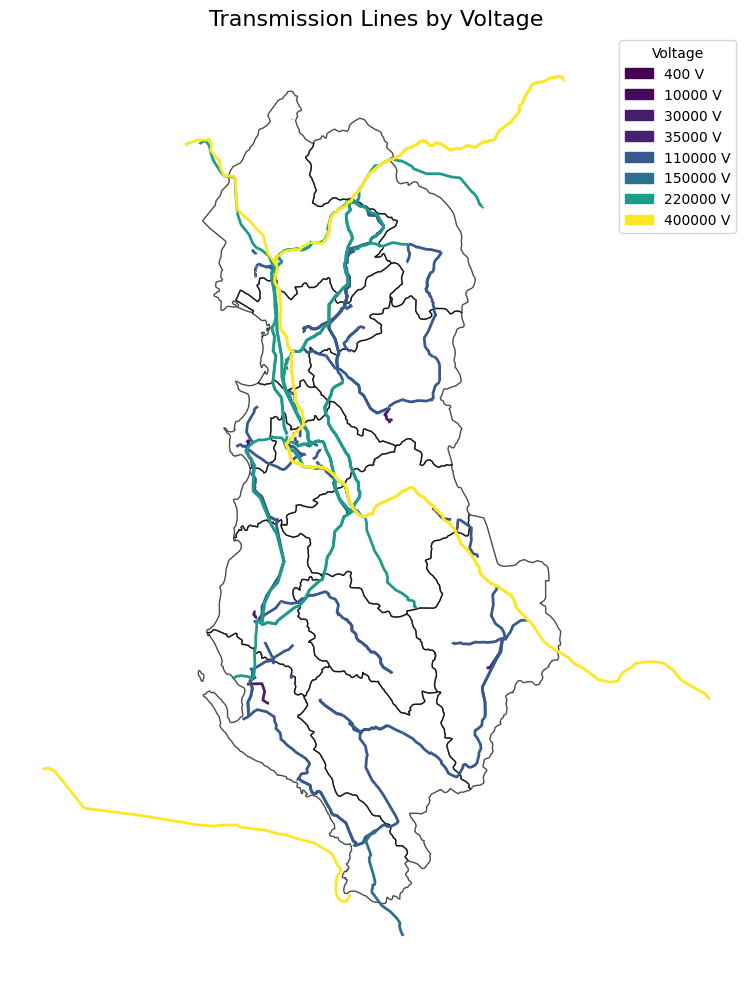

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))
boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, alpha=0.7)

if 'voltage' in lines.columns:
    # Convert voltages to numeric, coerce errors to NaN, then drop NaN
    voltages = pd.to_numeric(lines['voltage'], errors='coerce').dropna().unique()
    voltages.sort()
    cmap = plt.cm.viridis
    norm = plt.Normalize(voltages.min(), voltages.max())
    colors = [cmap(norm(v)) for v in voltages]
    for v, color in zip(voltages, colors):
        lines[pd.to_numeric(lines['voltage'], errors='coerce') == v].plot(ax=ax, color=color, linewidth=2, label=str(int(v)))
    legend_patches = [mpatches.Patch(color=color, label=f"{int(v)} V") for v, color in zip(voltages, colors)]
    ax.legend(handles=legend_patches, title='Voltage')
    ax.set_title('Transmission Lines by Voltage', fontsize=16)
else:
    lines.plot(ax=ax, color='blue', linewidth=1)
    ax.set_title('Transmission Lines', fontsize=16)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [20]:
from RES.visuals import add_compass_to_plot

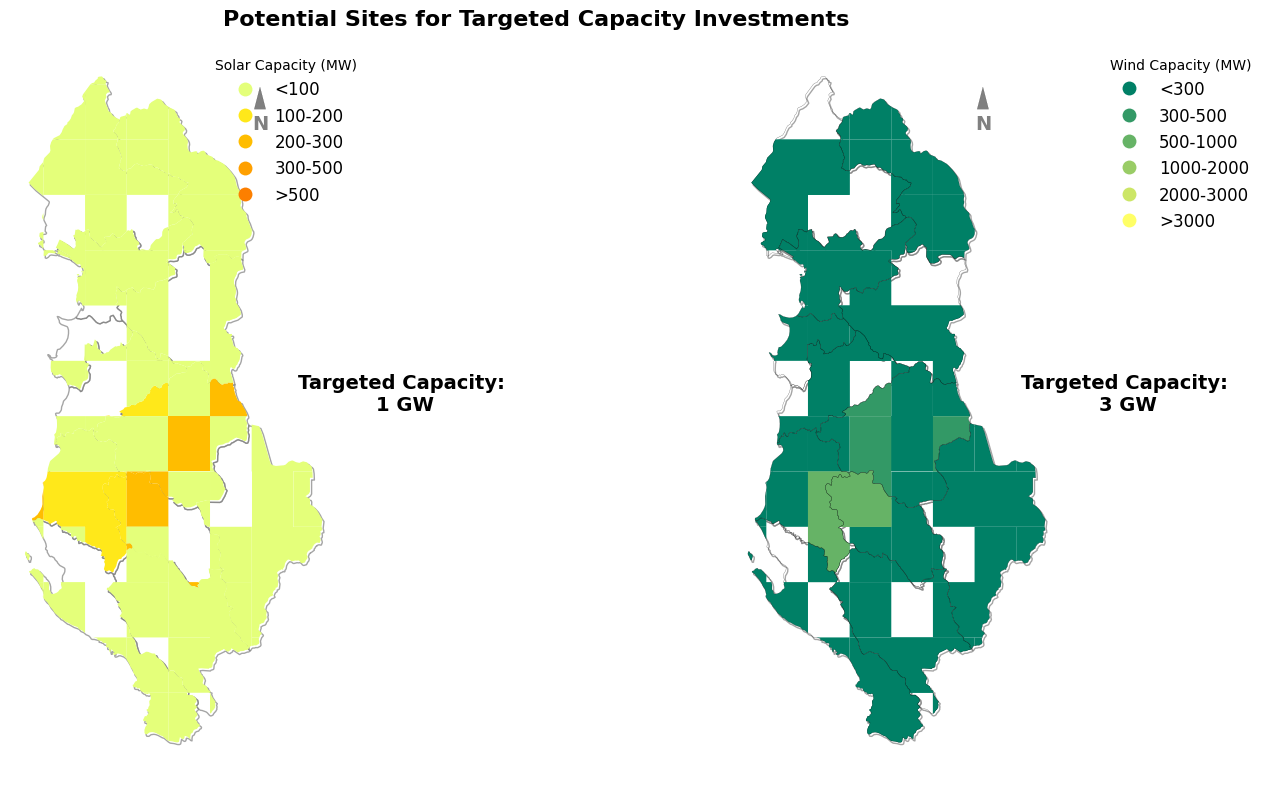

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

legend_x_ax_offset=1.1

# Ensure 'Region' is in the columns for both boundary and cells
# if boundary is not None and ('Region' not in boundary.columns or 'Country' not in boundary.columns):
#     boundary = boundary.reset_index()

# Assign a number to each region
# boundary['Region_Number'] = range(1, len(boundary) + 1)

# Define custom bins and labels for solar and wind capacity
solar_bins = [0, 100, 200, 300, 500, float('inf')]  # Custom ranges
solar_labels = ['<100','100-200', '200-300', '300-500','>500']  # Labels for legend

# Define custom bins and labels for solar and wind capacity
wind_bins = [0, 300, 500, 1000, 2000,3000, float('inf')]  # Custom ranges
wind_labels = ['<300','300-500', '500-1000', '1000-2000','2000-3000', '>3000']  # Labels for legend

# Categorize potential_capacity_solar and potential_capacity_wind into bins
resource_clusters_solar['solar_category'] = pd.cut(resource_clusters_solar['potential_capacity'], bins=solar_bins, labels=solar_labels, include_lowest=True)
resource_clusters_wind['wind_category'] = pd.cut(resource_clusters_wind['potential_capacity'], bins=wind_bins, labels=wind_labels, include_lowest=True)

# Create figure and axes for side-by-side plotting
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2)
fig.suptitle("Potential Sites for Targeted Capacity Investments", fontsize=16,weight='bold')
# Set axis off for both subplots
ax1.set_axis_off()
ax2.set_axis_off()

# Shadow effect offset
shadow_offset = 0.01

# Plot solar map on ax1
# Add shadow effect for solar map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax1, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot solar cells
resource_clusters_solar.plot(column='solar_category', ax=ax1, cmap='Wistia', legend=True, 
           legend_kwds={'title': "Solar Capacity (MW)", 'loc': 'upper right','fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for solar map
# boundary.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for solar map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=7, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Plot wind map on ax2
# Add shadow effect for wind map
boundary.geometry = boundary.geometry.translate(xoff=shadow_offset, yoff=-shadow_offset)
boundary.plot(ax=ax2, color='None', edgecolor='grey', linewidth=1, alpha=0.7)  # Shadow layer
boundary.geometry = boundary.geometry.translate(xoff=-shadow_offset, yoff=shadow_offset)

# Plot wind cells
resource_clusters_wind.plot(column='wind_category', ax=ax2, cmap='summer', legend=True, 
           legend_kwds={'title': "Wind Capacity (MW)", 'fontsize':12,'bbox_to_anchor':(legend_x_ax_offset,1), 'frameon': False})

# Plot actual boundary for wind map
boundary.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.2, alpha=0.7)
"""
# Annotate region numbers for wind map
for idx, row in boundary.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(f"{row['Region_Number']}", 
                 xy=(centroid.x, centroid.y), 
                 ha='center', va='center',
                 fontsize=8, color='black',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2'))
"""
# Adjust layout for cleaner appearance
fig.patch.set_alpha(0)  # Make figure background transparent
plt.tight_layout()


# Add annotation for solar capacity
ax1.annotate(f"Targeted Capacity: \n{int(resource_clusters_solar.potential_capacity.sum()/1e3)} GW",
             xy=(1.2, 0.5), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')

# Add annotation for wind capacity
ax2.annotate(f"Targeted Capacity: \n{int(resource_clusters_wind.potential_capacity.sum()/1e3)} GW",
             xy=(1.2, 0.5), xycoords='axes fraction', ha='center', 
             fontsize=14, color='black', fontweight='bold')
# Show the side-by-side plot

plt.savefig('vis/solar_wind_capacity_map.png',dpi=300)
# Add a directional compass (north arrow) to both subplots
# Use a more standard north arrow style
add_compass_to_plot(ax1)
add_compass_to_plot(ax2)
plt.show()

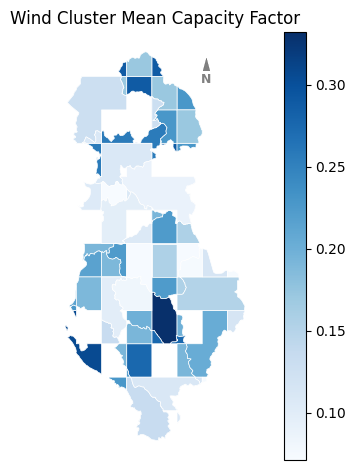

In [22]:
ax = wind_clusters.plot(column='CF_mean', cmap='Blues', legend=True, edgecolor='white', linewidth=0.5)
ax.set_title("Wind Cluster Mean Capacity Factor", fontsize=12)
ax.set_axis_off()
add_compass_to_plot(ax,size=9)
plt.tight_layout()
plt.show()

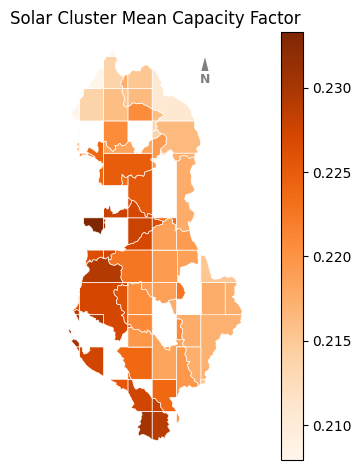

In [23]:
ax =solar_clusters.plot(column='CF_mean', cmap='Oranges', legend=True, edgecolor='white', linewidth=0.5)
ax.set_title("Solar Cluster Mean Capacity Factor", fontsize=12)
ax.set_axis_off()
add_compass_to_plot(ax,size=9)
plt.tight_layout()
plt.show()